In [44]:
import pandas as pd
import os, sys
import numpy as np

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))
from utils.prediction_utils import *

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)


In [26]:
# Load your data using the get_data function
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("mm", base_dir, sample_rate=1.0)

# Combine X and y into a single DataFrame for convenience
df = pd.concat([X, y], axis=1)
df.info()

# Ensure dtype columns are of integer type
X = X.astype({"dtype_16": int, "dtype_32": int, "dtype_b16": int})
X = X.query("dtype_32")

100%|██████████| 72/72 [01:35<00:00,  1.32s/it]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247616 entries, 0 to 1247615
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   n          1247616 non-null  int64  
 1   m          1247616 non-null  int64  
 2   p          1247616 non-null  int64  
 3   gflops     1247616 non-null  float64
 4   dtype_16   1247616 non-null  bool   
 5   dtype_32   1247616 non-null  bool   
 6   dtype_b16  1247616 non-null  bool   
 7   time       1247616 non-null  float64
dtypes: bool(3), float64(2), int64(3)
memory usage: 51.2 MB


Epoch [1/5], Training Loss: 3434.6007, Validation Loss: 3471.6178
Min predicted_alpha: 0.01807200163602829, Max predicted_alpha: 0.5252485275268555
Epoch [2/5], Training Loss: 3436.4747, Validation Loss: 3471.5128
Min predicted_alpha: 0.02615918405354023, Max predicted_alpha: 0.31531277298927307
Epoch [3/5], Training Loss: 3435.5290, Validation Loss: 3471.4043
Min predicted_alpha: 0.025521600618958473, Max predicted_alpha: 0.25820428133010864
Epoch [4/5], Training Loss: 3434.3974, Validation Loss: 3471.3467
Min predicted_alpha: 0.02394854463636875, Max predicted_alpha: 0.23929443955421448
Epoch [5/5], Training Loss: 3437.4905, Validation Loss: 3471.5333
Min predicted_alpha: 0.023354869335889816, Max predicted_alpha: 0.21942345798015594


/var/folders/c8/q9xddvxj5pv262qffnm05sk00000gn/T/ipykernel_94246/1139185382.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mode

Final Validation Loss: 3471.3467


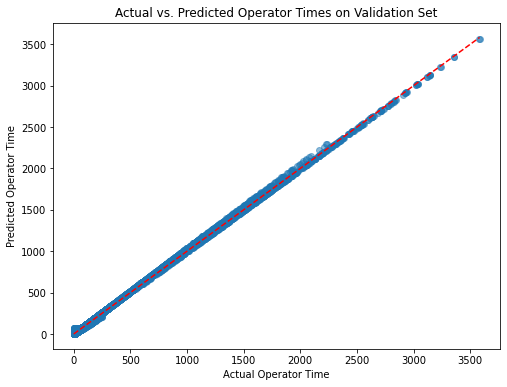

In [32]:
decay_param = 0.93

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_array = X_scaled  # Use scaled features
y_array = y.values  # Target variable as numpy array

# Compute additional features
def get_dtype_bytes(row):
    if row['dtype_32']:
        return 4
    elif row['dtype_16']:
        return 2
    elif row['dtype_b16']:
        return 2
    else:
        raise ValueError("Unknown dtype in row.")

# Compute memory accesses and intensity for the entire dataset
memory_accesses = (
    df["n"] * df["m"] + df["m"] * df["p"] + df["n"] * df["p"]
) * df.apply(get_dtype_bytes, axis=1) / 1e9  # in GB

intensity = df["gflops"] / memory_accesses

# Convert to numpy arrays
memory_accesses_array = memory_accesses.values  # NumPy array
intensity_array = intensity.values  # NumPy array

def get_dtype_peak_fp(row):
    if row['dtype_32']:
        return 19.5
    elif row['dtype_16']:
        return 312
    elif row['dtype_b16']:
        return 312
    else:
        raise ValueError("Unknown dtype in row.")

# Compute pi for the entire dataset
pi_array = df.apply(get_dtype_peak_fp, axis=1).values  # in GFLOPs

# Define beta (DRAM bandwidth in GB/ms)
beta = 2.03904

# Split data into training and validation sets, including additional features
X_train, X_val, y_train, y_val, memory_accesses_train, memory_accesses_val, intensity_train, intensity_val, pi_train, pi_val = train_test_split(
    X_array, y_array, memory_accesses_array, intensity_array, pi_array,
    test_size=0.2, random_state=random_seed
)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

memory_accesses_train_tensor = torch.tensor(memory_accesses_train, dtype=torch.float32)
memory_accesses_val_tensor = torch.tensor(memory_accesses_val, dtype=torch.float32)

intensity_train_tensor = torch.tensor(intensity_train, dtype=torch.float32)
intensity_val_tensor = torch.tensor(intensity_val, dtype=torch.float32)

pi_train_tensor = torch.tensor(pi_train, dtype=torch.float32)
pi_val_tensor = torch.tensor(pi_val, dtype=torch.float32)

# Create TensorDatasets for training and validation sets
train_dataset = TensorDataset(
    X_train_tensor, y_train_tensor, memory_accesses_train_tensor, intensity_train_tensor, pi_train_tensor
)
val_dataset = TensorDataset(
    X_val_tensor, y_val_tensor, memory_accesses_val_tensor, intensity_val_tensor, pi_val_tensor
)

# Define batch size
batch_size = 1024

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def weighted_mse_loss(y_true, y_pred, weight):
    loss = weight * (y_true - y_pred) ** 2
    return loss.mean()

def mape_loss(y_true, y_pred):
    epsilon = 1e-8  # to prevent division by zero
    loss = torch.abs((y_true - y_pred) / (y_true + epsilon))  # Add epsilon for stability
    return torch.mean(loss)

# Define the custom loss function
def custom_loss_function(predicted_alpha, target_operator_time, batch_memory_accesses, batch_intensity, batch_pi, beta):
    """
    predicted_alpha: Output from the neural network (predicted alpha)
    target_operator_time: Actual operator times (ground truth)
    batch_memory_accesses: Memory accesses for the batch
    batch_intensity: Arithmetic intensity for the batch
    batch_pi: Peak FLOPs/sec for the batch
    beta: Predefined DRAM bandwidth
    """

    batch_total_flops = batch_intensity * batch_memory_accesses  # GFLOPs
    predicted_alpha = predicted_alpha.clamp(min=1e-6)
    estimated_operator_time = torch.max(
        batch_total_flops / (batch_pi * decay_param),
        batch_memory_accesses / (predicted_alpha * beta)
    )

    # weights = 1 + target_operator_time / max(target_operator_time)  # Higher weights for larger operator times
    # loss = weighted_mse_loss(target_operator_time, estimated_operator_time, weights)

    # log_target_operator_time = torch.log1p(target_operator_time)
    # loss = torch.nn.functional.mse_loss(torch.log1p(estimated_operator_time), log_target_operator_time)

    # loss = mape_loss(target_operator_time, estimated_operator_time)
    loss = torch.nn.functional.mse_loss(estimated_operator_time, target_operator_time)
    return loss

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_p=0.2):
        super(Net, self).__init__()
        layers = []
        in_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_p))  # Add Dropout layer
            in_size = hidden_size

        layers.append(nn.Linear(in_size, output_size))
        layers.append(nn.Sigmoid())  # Ensure output is between 0 and 1
        # layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).clamp(min=1e-2)

# Define model parameters
input_size = X_train_tensor.shape[1]
hidden_sizes = [256, 128, 64, 64, 32]
output_size = 1  # Predicting alpha

# Initialize the model
model = Net(input_size, hidden_sizes, output_size, dropout_p=0.0)

# Define optimizer without weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.0001)  # No weight_decay

# Number of epochs
num_epochs = 5

# For early stopping
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop with validation
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    min_predicted_alpha = float('inf')
    max_predicted_alpha = float('-inf')

    for batch_X, batch_y, batch_memory_accesses, batch_intensity, batch_pi in train_loader:
        # Forward pass: predict alpha
        predicted_alpha = model(batch_X).squeeze()  # .squeeze() to align shapes
        min_predicted_alpha = min(min_predicted_alpha, predicted_alpha.min().item())
        max_predicted_alpha = max(max_predicted_alpha, predicted_alpha.max().item())

        # Compute loss
        loss = custom_loss_function(
            predicted_alpha, batch_y, batch_memory_accesses, batch_intensity, batch_pi, beta
        )

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average training loss
    avg_train_loss = train_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X_val, batch_y_val, batch_memory_accesses_val, batch_intensity_val, batch_pi_val in val_loader:
            # Forward pass
            predicted_alpha_val = model(batch_X_val).squeeze()

            # Compute loss
            loss_val = custom_loss_function(
                predicted_alpha_val, batch_y_val, batch_memory_accesses_val, batch_intensity_val, batch_pi_val, beta
            )

            val_loss += loss_val.item()

    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f"Min predicted_alpha: {min_predicted_alpha}, Max predicted_alpha: {max_predicted_alpha}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping!")
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on validation set
model.eval()
val_loss = 0.0
with torch.no_grad():
    for batch_X_val, batch_y_val, batch_memory_accesses_val, batch_intensity_val, batch_pi_val in val_loader:
        # Forward pass
        predicted_alpha_val = model(batch_X_val).squeeze()

        # Compute loss
        loss_val = custom_loss_function(
            predicted_alpha_val, batch_y_val, batch_memory_accesses_val, batch_intensity_val, batch_pi_val, beta
        )

        val_loss += loss_val.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f'Final Validation Loss: {avg_val_loss:.4f}')

# Get predictions and actual values for the validation set
all_predicted_times = []
all_actual_times = []
with torch.no_grad():

    for batch_X_val, batch_y_val, batch_memory_accesses_val, batch_intensity_val, batch_pi_val in val_loader:
        # Forward pass: Predict alpha
        predicted_alpha_val = model(batch_X_val).squeeze()

        # Compute total FLOPs for this batch
        batch_total_flops_val = batch_intensity_val * batch_memory_accesses_val  # GFLOPs

        # Ensure no zero values for predicted alpha
        predicted_alpha_val = predicted_alpha_val.clamp(min=1e-6)

        # Calculate estimated operator time
        estimated_operator_time_val = torch.max(
            batch_total_flops_val / (batch_pi_val * 0.95),
            batch_memory_accesses_val / (predicted_alpha_val * beta)
        )

        # Inverse log transformation to get the original scale
        # estimated_operator_time_val = torch.expm1(estimated_operator_time_val)

        # Store predictions and actual values
        all_predicted_times.append(estimated_operator_time_val.numpy())
        all_actual_times.append(batch_y_val.numpy())

# Concatenate all batches
all_predicted_times = np.concatenate(all_predicted_times)
all_actual_times = np.concatenate(all_actual_times)

# Plot actual vs. predicted operator times
plt.figure(figsize=(8, 6))
plt.scatter(all_actual_times, all_predicted_times, alpha=0.5)
plt.xlabel('Actual Operator Time')
plt.ylabel('Predicted Operator Time')
plt.title('Actual vs. Predicted Operator Times on Validation Set')
plt.plot([all_actual_times.min(), all_actual_times.max()], [all_actual_times.min(), all_actual_times.max()], 'r--')
plt.show()


Mean Squared Error: 24.679832458496094
MAPE: 1.2123350225841834
R-squared: 0.9982955322552286


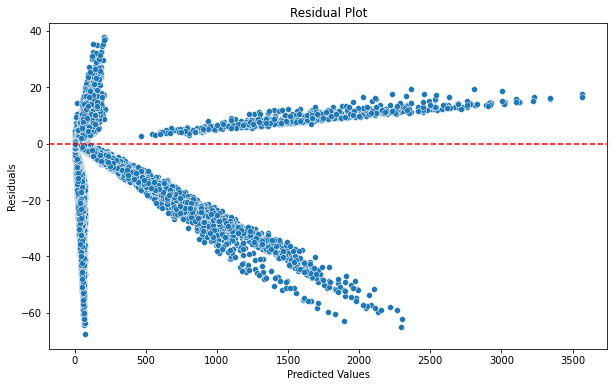

In [43]:
get_r2_score(all_actual_times, all_predicted_times)
plot_residuals(all_actual_times, all_predicted_times) # use_log_scale=True

# Classification attempt

In [54]:
def group_residuals(residuals, predicted):
    """
    Groups residuals into different categories.
    
    Group 0: Small residuals (close to zero)
    Group 1: Large negative residuals
    Group 2: Large positive residuals
    """
    # Define thresholds for small, negative, and positive residuals
    small_threshold = 500  # Adjust based on your data

    # Create groups based on residual size and sign
    residual_groups = np.zeros(residuals.shape)  # Initialize with group 0 (small residuals)

    residual_groups[(predicted < small_threshold) & (residuals >= 0)] = 0

    residual_groups[(predicted > small_threshold) & (residuals >= 0)] = 1
    
    residual_groups[(predicted < small_threshold) & (residuals < 0)] = 2

    residual_groups[(predicted > small_threshold) & (residuals < 0)] = 3

    return residual_groups


In [55]:
# Compute residuals (actual - predicted)
residuals = all_actual_times - all_predicted_times

# Group residuals into categories
residual_groups = group_residuals(residuals, all_predicted_times)

# Features for classification (same as before)
X_classification = X_val_tensor.numpy()  # Assuming features are the same as for the regression task

# Labels for classification (the residual groups)
y_classification = residual_groups  # This is your target for classification


In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data into train and test sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_cls, y_train_cls)

# Make predictions on the test set
y_pred_cls = clf.predict(X_test_cls)

# Evaluate the classifier
print(classification_report(y_test_cls, y_pred_cls))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15810
         1.0       0.00      0.00      0.00       112
         2.0       0.67      1.00      0.81     33675
         3.0       0.00      0.00      0.00       308

    accuracy                           0.67     49905
   macro avg       0.17      0.25      0.20     49905
weighted avg       0.46      0.67      0.54     49905



/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

# Previous work: ignore

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("mm", base_dir, sample_rate=0.2)

# Combine X and y into a single DataFrame for convenience
df = pd.concat([X, y], axis=1)
df.info()

# Ensure dtype columns are of integer type
X = X.astype({"dtype_16": int, "dtype_32": int, "dtype_b16": int})

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_array = X_scaled  # Use scaled features
y_array = y.values  # Target variable as numpy array

100%|██████████| 72/72 [00:19<00:00,  3.73it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249552 entries, 0 to 249551
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   n          249552 non-null  int64  
 1   m          249552 non-null  int64  
 2   p          249552 non-null  int64  
 3   gflops     249552 non-null  float64
 4   dtype_16   249552 non-null  bool   
 5   dtype_32   249552 non-null  bool   
 6   dtype_b16  249552 non-null  bool   
 7   time       249552 non-null  float64
dtypes: bool(3), float64(2), int64(3)
memory usage: 10.2 MB


In [3]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_array, y_array, test_size=0.2, random_state=random_seed
)

# Indices for tracking original positions (optional)
indices_train = np.arange(len(X_train))
indices_val = np.arange(len(X_val))

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [4]:
def get_dtype_bytes(row):
    if row['dtype_32']:
        return 4
    elif row['dtype_16']:
        return 2
    elif row['dtype_b16']:
        return 2
    else:
        raise ValueError("Unknown dtype in row.")

# Compute memory accesses and intensity for the entire dataset
memory_accesses = (
    df["n"] * df["m"] + df["m"] * df["p"] + df["n"] * df["p"]
) * df.apply(get_dtype_bytes, axis=1) / 1e9  # in GB

intensity = df["gflops"] / memory_accesses

# Convert to numpy arrays
memory_accesses_array = memory_accesses.values
intensity_array = intensity.values

def get_dtype_peak_fp(row):
    if row['dtype_32']:
        return 19.5
    elif row['dtype_16']:
        return 312
    elif row['dtype_b16']:
        return 312
    else:
        raise ValueError("Unknown dtype in row.")

# Compute pi for the entire dataset
pi = df.apply(get_dtype_peak_fp, axis=1).values  # in GFLOPs

# Define beta (DRAM bandwidth in GB/ms)
beta = 2.03904


In [5]:
def get_dtype_peak_fp(row):
    # 156 for tf32.
    if row['dtype_32']:
        return 19.5
    elif row['dtype_16']:
        return 312
    elif row['dtype_b16']:
        return 312
    else:
        raise ValueError("Unknown dtype in row.")

# Note: hard-coded for A100.
# this is gb/ms.
beta = 2.03904

# gb/ms
pi = X.apply(get_dtype_peak_fp, axis=1)
pi = torch.tensor(pi.values, dtype=torch.float32)

# Since we've shuffled the data during train_test_split, we need to split the additional features accordingly
memory_accesses_train = memory_accesses_array[X_train.index]
memory_accesses_val = memory_accesses_array[X_val.index]

intensity_train = intensity_array[X_train.index]
intensity_val = intensity_array[X_val.index]

pi_train = pi[X_train.index]
pi_val = pi[X_val.index]

memory_accesses_train_tensor = torch.tensor(memory_accesses_train, dtype=torch.float32)
memory_accesses_val_tensor = torch.tensor(memory_accesses_val, dtype=torch.float32)

intensity_train_tensor = torch.tensor(intensity_train, dtype=torch.float32)
intensity_val_tensor = torch.tensor(intensity_val, dtype=torch.float32)

pi_train_tensor = torch.tensor(pi_train, dtype=torch.float32)
pi_val_tensor = torch.tensor(pi_val, dtype=torch.float32)



AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
# Create TensorDatasets for training and validation sets
train_dataset = TensorDataset(
    X_train_tensor, y_train_tensor, memory_accesses_train_tensor, intensity_train_tensor, pi_train_tensor
)
val_dataset = TensorDataset(
    X_val_tensor, y_val_tensor, memory_accesses_val_tensor, intensity_val_tensor, pi_val_tensor
)

# Define batch size
batch_size = 1024

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [95]:
def custom_loss_function(predicted_alpha, target_operator_time, batch_memory_accesses, batch_intensity, batch_pi, beta):
    """
    predicted_alpha: Output from the neural network (predicted alpha)
    target_operator_time: Actual operator times (ground truth)
    batch_memory_accesses: Memory accesses for the batch
    batch_intensity: Arithmetic intensity for the batch
    batch_pi: Peak FLOPs/sec for the batch
    beta: Predefined DRAM bandwidth
    """
    # Compute total FLOPs
    batch_total_flops = batch_intensity * batch_memory_accesses  # GFLOPs

    # Calculate the estimated operator time using the predicted alpha
    estimated_operator_time = torch.max(
        batch_total_flops / batch_pi,
        batch_memory_accesses / (predicted_alpha * beta + 1e-6)  # Add small value to avoid division by zero
    )

    # Use MSE between the estimated and actual operator times as the loss
    loss = torch.nn.functional.mse_loss(estimated_operator_time, target_operator_time)
    
    return loss


In [96]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_p=0.5):
        super(Net, self).__init__()
        layers = []
        in_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_p))  # Add Dropout layer
            in_size = hidden_size

        layers.append(nn.Linear(in_size, output_size))
        layers.append(nn.Sigmoid())  # Ensure output is between 0 and 1
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [ ]:
# Define model parameters
input_size = X_train_tensor.shape[1]
hidden_sizes = [128, 64, 32]
output_size = 1  # Predicting alpha

# Initialize the model
model = Net(input_size, hidden_sizes, output_size, dropout_p=0.5)

# Define optimizer without weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  # No weight_decay


In [97]:
# Number of epochs
num_epochs = 100

# For early stopping
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y, batch_memory_accesses, batch_intensity, batch_pi in train_loader:
        # Forward pass: predict alpha
        predicted_alpha = model(batch_X).squeeze()  # .squeeze() to align shapes

        # Compute loss
        loss = custom_loss_function(
            predicted_alpha, batch_y, batch_memory_accesses, batch_intensity, batch_pi, beta
        )

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X_val, batch_y_val, batch_memory_accesses_val, batch_intensity_val, batch_pi_val in val_loader:
            # Forward pass
            predicted_alpha_val = model(batch_X_val).squeeze()
            
            # Compute loss
            loss_val = custom_loss_function(
                predicted_alpha_val, batch_y_val, batch_memory_accesses_val, batch_intensity_val, batch_pi_val, beta
            )
            
            val_loss += loss_val.item()
    
    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print("Early stopping!")
        break


Epoch [1/100], Loss: 31.4133
Epoch [2/100], Loss: 31.4416
Epoch [3/100], Loss: 31.4451
Epoch [4/100], Loss: 31.4061
Epoch [5/100], Loss: 31.4021
Epoch [6/100], Loss: 31.5378
Epoch [7/100], Loss: 31.4683
Epoch [8/100], Loss: 31.4534
Epoch [9/100], Loss: 31.4151
Epoch [10/100], Loss: 31.4717
Epoch [11/100], Loss: 31.4236
Epoch [12/100], Loss: 31.4521
Epoch [13/100], Loss: 31.4838
Epoch [14/100], Loss: 31.4188
Epoch [15/100], Loss: 31.4524
Epoch [16/100], Loss: 31.4933
Epoch [17/100], Loss: 31.4286
Epoch [18/100], Loss: 31.4300
Epoch [19/100], Loss: 31.4388
Epoch [20/100], Loss: 31.4024
Epoch [21/100], Loss: 31.4108
Epoch [22/100], Loss: 31.4366
Epoch [23/100], Loss: 31.4955
Epoch [24/100], Loss: 31.4487
Epoch [25/100], Loss: 31.4102
Epoch [26/100], Loss: 31.4317
Epoch [27/100], Loss: 31.4409
Epoch [28/100], Loss: 31.4412
Epoch [29/100], Loss: 31.4019
Epoch [30/100], Loss: 31.4308
Epoch [31/100], Loss: 31.4477
Epoch [32/100], Loss: 31.4597
Epoch [33/100], Loss: 31.4967
Epoch [34/100], Los

# First: try to make a NN that predicts time

In [ ]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("mm", base_dir, sample_rate=0.2)

# Saving the result somewhere in case.
X = pd.concat([X, y], axis=1)
X.info()

X = X.astype({"dtype_16": int, "dtype_32": int, "dtype_b16": int})

100%|██████████| 72/72 [00:20<00:00,  3.46it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249552 entries, 0 to 249551
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   n          249552 non-null  int64  
 1   m          249552 non-null  int64  
 2   p          249552 non-null  int64  
 3   gflops     249552 non-null  float64
 4   dtype_16   249552 non-null  bool   
 5   dtype_32   249552 non-null  bool   
 6   dtype_b16  249552 non-null  bool   
 7   time       249552 non-null  float64
dtypes: bool(3), float64(2), int64(3)
memory usage: 10.2 MB


In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [27]:
dataset = TensorDataset(X_tensor, y_tensor)

# Create a DataLoader with a batch size of 1024 (you can adjust this depending on your memory limits)
batch_size = 1024
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
input_size = X_tensor.shape[1]
hidden_size = 32
output_size = 1  # Predicting time
model = Net(input_size, hidden_size, output_size)


# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop using the DataLoader and custom loss function
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (batch_X, batch_y) in enumerate(data_loader):
        # Forward pass: predict alpha
        y_pred = model(batch_X).squeeze()  # .squeeze() to align shapes
        
        loss = torch.nn.functional.mse_loss(y_pred, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        epoch_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(data_loader):.4f}')

Epoch [1/100], Loss: 9428.7473
Epoch [2/100], Loss: 154.8481
Epoch [3/100], Loss: 31.9019
Epoch [4/100], Loss: 22.1886
Epoch [5/100], Loss: 19.0369
Epoch [6/100], Loss: 18.5404
Epoch [7/100], Loss: 18.7222
Epoch [8/100], Loss: 18.5803
Epoch [9/100], Loss: 17.1532
Epoch [10/100], Loss: 17.8188
Epoch [11/100], Loss: 18.6126
Epoch [12/100], Loss: 19.6025
Epoch [13/100], Loss: 16.8465
Epoch [14/100], Loss: 15.8716
Epoch [15/100], Loss: 17.4483
Epoch [16/100], Loss: 17.9015
Epoch [17/100], Loss: 15.9723
Epoch [18/100], Loss: 16.4366
Epoch [19/100], Loss: 16.1780
Epoch [20/100], Loss: 19.3111
Epoch [21/100], Loss: 19.6489
Epoch [22/100], Loss: 16.5114
Epoch [23/100], Loss: 15.9459
Epoch [24/100], Loss: 17.2014
Epoch [25/100], Loss: 15.7752
Epoch [26/100], Loss: 16.6822
Epoch [27/100], Loss: 19.0313
Epoch [28/100], Loss: 15.7233
Epoch [29/100], Loss: 17.3925
Epoch [30/100], Loss: 16.1551
Epoch [31/100], Loss: 15.9069
Epoch [32/100], Loss: 15.8772
Epoch [33/100], Loss: 17.0302
Epoch [34/100], 

KeyboardInterrupt: 